# Simulating Stellar Flybys using [`REBOUND`](https://rebound.readthedocs.io/en/latest/index.html).

## Stellar Flyby Basics

A stellar flyby is when a star external to a planetary system passes by the system on a hyperbolic trajectory. The figure below shows four different examples of planar hyperbolic trajectories with different impact parameters and eccentricites passing by a Sun-Neptune system.

<img src="./images/hyperbolic_trajectories.png" alt="Hyperbolic trajectories with different impact parameters" height="400" width="400">

Like closed orbits, a hyperbolic trajectory can be defined by it's orbital elements. For example, the outermost trajectory has an impact parameter $b_\star=250$ AU and an eccentricity $e_\star=2.5$ (this gives a semi-major axis of $a_\star = -b_\star/\sqrt{e_\star^2 - 1} \approx -109$ AU). Note the negative semi-major axis.

Thus, if we wanted to setup a `REBOUND` simulation with these three objects it would be
```
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=5.15e-05, a=30.28, e=0.013)
sim.add(a=-109, e=2.5)
```
`REBOUND` will do a consistency check to make sure that if the eccentricity of an object is greater than 1 that its semi-major axis is also negative.

For a randomly oriented flyby star there are three main characteristics needed to compute the its initial conditions: the mass of the flyby star $m_\star$, the impact parameter $b_\star$, and the relative velocity or hyperbolic excess velocity $v_\star$. We found that these three parameters are the easiest to work with when drawing samples from distributions that define various stellar environments (see [Stellar Environments](./Stellar_Environments.ipynb) notebook for more details).

### Three-body system flyby (Sun-Neptune and flyby star).
As a basic example, we consider a stellar flyby to a Sun-Neptune system.

First we import `REBOUND`, `airball` `numpy`, and `matplotlib`. We also make sure to use a colour blind friendly palette.

In [1]:
import rebound
import airball
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.style as style
style.use('tableau-colorblind10')

#### Define constants and parameters
We also define some useful constants and parameters for setting up our system. We take the current values of Neptune's orbital elements but will first consider the planar case. Additionally, we pick a set of parameters for our stellar flyby as a specific example.

In [2]:
pi = np.pi
twopi = 2.*pi
to_deg = 180.0/pi

sun_mass = 1.0 # Msun

# Basic orbital elements of Neptune
planet_mass = 5.151383772628674e-05 # Msun
planet_a = 30.27762143269065 # AU
planet_e = 0.012971767987242259
# More if you don't want Neptune to be planar.
planet_inc = 0.030870657846206642
planet_omega = 4.337864438269479
planet_Omega = 2.2992717711122466

# Set the orbital elements of the flyby star
# Simulate a randomly oriented, 1 solar mass stellar flyby with relative velocity of 5 km/s, and an impact parameter of 150 AU.
star_mass = 1 # Msun
star_v = 5 # km/s
star_b = 150 # AU
star_inc = 1.12 #np.random.uniform(-pi, pi)
star_omega = 1.09 #np.random.uniform(-pi, pi)
star_Omega = 0.97 #np.random.uniform(-pi, pi)
print('star_inc:   {0:7.2f}°'.format(star_inc * to_deg))
print('star_omega: {0:7.2f}°'.format(star_omega * to_deg))
print('star_Omega: {0:7.2f}°'.format(star_Omega * to_deg))

star_inc:     64.17°
star_omega:   62.45°
star_Omega:   55.58°


#### Setup a two-body simulation and run a flyby simulation.
We define a function that returns a consistent `REBOUND` Simulation setup for convenience and reproducibility.

In [3]:
def setup(planet_mass=5.151383772628674e-05, planet_a=30.27762143269065, planet_e=0.012971767987242259, planet_inc=0, planet_omega=0, planet_Omega=0, planet_f=0):
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=sun_mass)
    sim.add(m=planet_mass, a=planet_a, e=planet_e, inc=planet_inc, omega=planet_omega, Omega=planet_Omega, f=planet_f)
    
    sim.integrator = 'whckl'
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.05 * sim.particles[1].P
    sim.move_to_com()
    return sim

##### The setup and the outcome.
Run the flyby simulation showing the details of the flyby setup with snapshots of the system before and after the flyby.

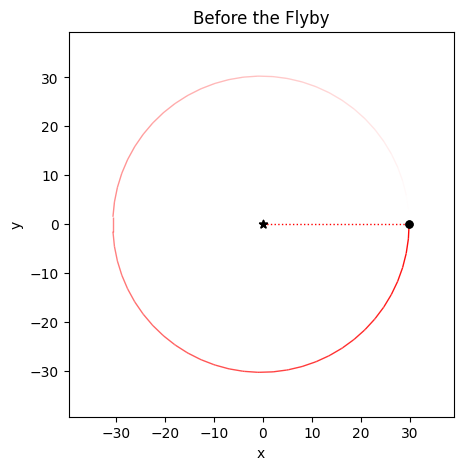

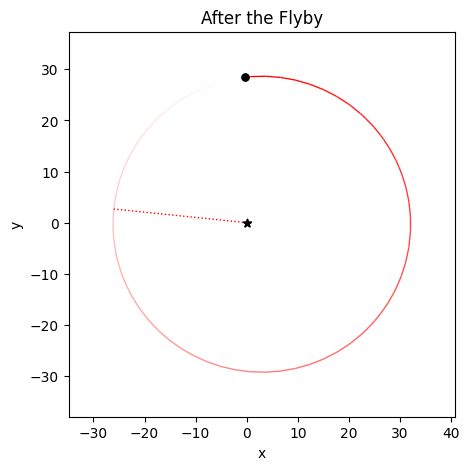

In [4]:
sim = setup(planet_inc=planet_inc)

rebound.OrbitPlot(sim, color=True, periastron=True);
plt.title('Before the Flyby')
plt.show()

sim_after = airball.flyby(sim, m=star_mass, b=star_b, v=star_v, inc=star_inc, omega=star_omega, Omega=star_Omega) 

rebound.OrbitPlot(sim_after, color=True, periastron=True);
plt.title('After the Flyby')
plt.show()

##### Rerun the same flyby and investigate how the system changed.
We can see from the snapshots above that the system was perturbed. We can rerun an identical simulation, but this time investigate what kind of relative effects the flyby had on the planet's energy, semi-major axis, and eccentricity. In the non-planar case we could also investigate the relative effects on the planet's inclination or whatever else we wanted.

In [5]:
sim = setup(planet_inc=planet_inc)

Ei = sim.energy()
orb = sim.calculate_orbits()
ai = orb[0].a
ei = orb[0].e
Ii = orb[0].inc

sim = airball.flyby(sim, m=star_mass, b=star_b, v=star_v, inc=star_inc, omega=star_omega, Omega=star_Omega) 

Ef = sim.energy()
orb = sim.calculate_orbits()
af = orb[0].a
ef = orb[0].e
If = orb[0].inc

dE = np.abs((Ef-Ei)/Ei)
da = np.abs((af-ai)/ai)
de = np.abs((ef-ei)/ei)
dI = np.abs((If-Ii)/Ii)

print('Relative Changes:')
print('dE/E = {0:1.5e}'.format(dE))
print('da/a = {0:1.5e}'.format(da))
print('de/e = {0:1.5e}'.format(de))
print('dI/I = {0:1.5e}'.format(dI))

Relative Changes:
dE/E = 3.92829e-02
da/a = 3.77981e-02
de/e = 6.86339e+00
dI/I = 3.15782e-01


## Implementation Details

We found that  when probing changes to a system from an adiabatic flyby (when the velocity of the incoming star is much less than the velocity of the planets) it is important to begin with the star at least $10^6\,\mathrm{AU}$ away from the Sun.

### Investigate the effects from a flyby with respect to impact parameter.

The effects of a stellar flyby on a star-planet depends exponentially on the perihelion distance. We can investigate this by running a couple hundred flyby scenarios while systematically changing the perihelion distance. If each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters.



The following takes about 90 seconds to run on an M1 Macbook Air.

In [6]:
ma = airball.tools.moving_average

In [7]:
star_v = 1
Nflybys = 500
energy = np.zeros(Nflybys+1)
e = np.zeros(Nflybys+1)
analytic_dE = np.zeros(Nflybys)
analytic_de = np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)

sim = setup()
energy[0] = sim.energy()
orb = sim.calculate_orbits()
e[0] = orb[0].e

star_bs = np.logspace(np.log10(planet_a), np.log10(planet_a * 1e4), Nflybys)
star_inc = np.random.uniform(-pi, pi, size=Nflybys)
star_omega = np.random.uniform(-pi, pi, size=Nflybys)
star_Omega = np.random.uniform(-pi, pi, size=Nflybys)

sims = [setup() for i in range(Nflybys)]
sim_results = airball.flybys(sims, m=star_mass, b=star_bs, v=star_v, inc=star_inc, omega=star_omega, Omega=star_Omega, rmax=1e6)

for i in range(Nflybys):
    analytic_dE[i] = np.abs(airball.relative_energy_change(1.0, planet_mass, planet_a, planet_e, star_mass, star_bs[i], star_v, star_omega=star_omega[i], star_Omega=star_Omega[i], star_inc=star_inc[i]))
    analytic_de[i] = np.abs(airball.eccentricity_change_adiabatic_estimate(1.0, planet_mass, planet_a, planet_e, star_mass, star_bs[i], star_v, star_omega=star_omega[i], star_Omega=star_Omega[i], star_inc=star_inc[i])/e[0])
    
    energy[i+1] = sim_results[i].energy()
    nsteps[i] = sim_results[i].steps_done
    orb = sim_results[i].calculate_orbits()
    e[i+1] = orb[0].e

dE = np.abs((energy[1:]-energy[0])/energy[0])
de = np.abs((e[1:]-e[0])/e[0])

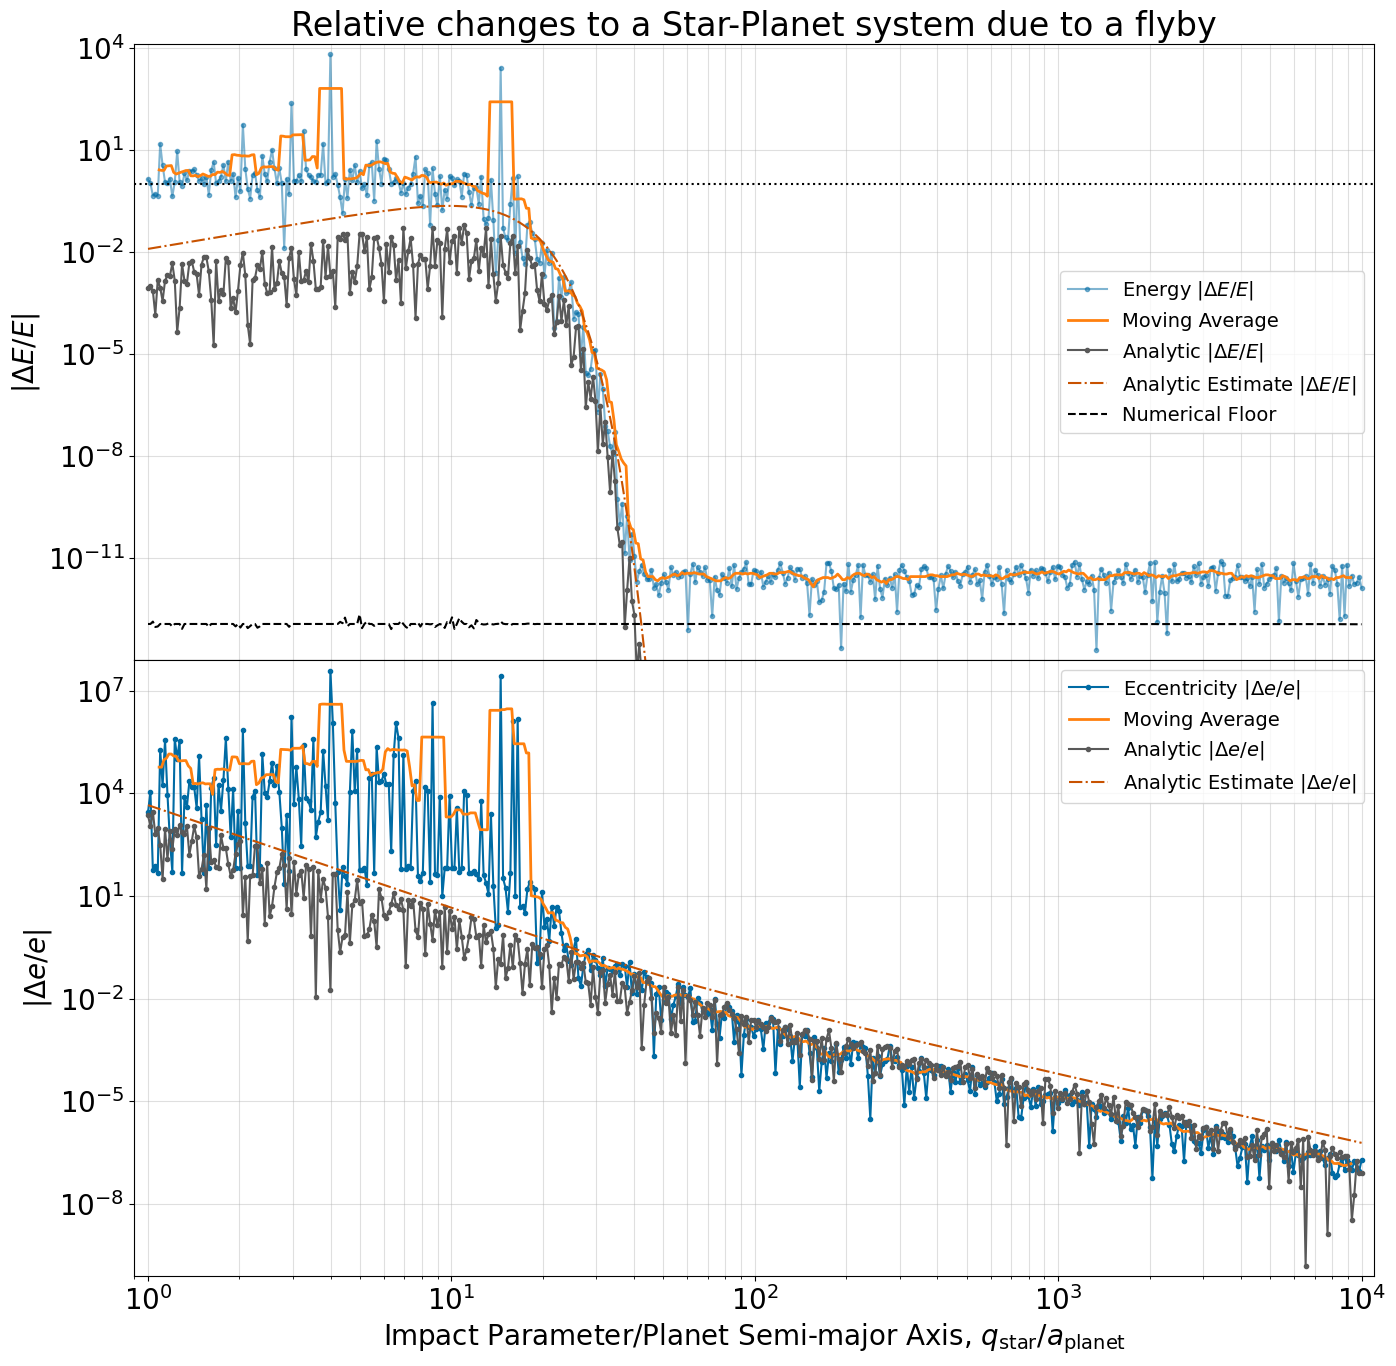

In [8]:
b_a = star_bs/planet_a
est_dE = np.abs(airball.relative_energy_change(sun_mass, planet_mass, planet_a, planet_e, star_mass, star_bs, star_v, averaged=True))
est_de = np.abs(airball.eccentricity_change_adiabatic_estimate(sun_mass, planet_mass, planet_a, planet_e, star_mass, star_bs, star_v, averaged=True)/planet_e)

plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(2,1, figsize=(16,16), sharex=True)
ax[0].set_title('Relative changes to a Star-Planet system due to a flyby')

ax[0].plot(b_a, dE, 'C0.-', alpha=0.5, label=r'Energy $|\Delta E/E|$')
ax[0].plot(ma(b_a, n=10), ma(dE, n=10), 'C1-', lw=2, label='Moving Average')
ax[0].plot(b_a, analytic_dE, 'C3.-', label=r'Analytic $|\Delta E/E|$')
ax[0].plot(b_a, est_dE, 'C5-.', label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].plot(b_a, 2.0**(-53.0) * np.sqrt(nsteps), 'k--', label='Numerical Floor')
ax[0].axhline(y=1, ls=':', c='k')
ax[0].legend(prop={'size': 14})
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].xaxis.grid(True, which='both', alpha=0.4)
ax[0].yaxis.grid(True, which='both', alpha=0.4)
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(b_a)*0.9, np.max(b_a)*1.1])
ax[0].set_ylim([np.min(dE)/2, np.max(dE)*2])

ax[1].plot(b_a, de, 'C0.-', label=r'Eccentricity $|\Delta e/e|$')
ax[1].plot(ma(b_a, n=10), ma(de, n=10), 'C1-', lw=2, label='Moving Average')
ax[1].plot(b_a, analytic_de, 'C3.-', label=r'Analytic $|\Delta e/e|$')
ax[1].plot(b_a, est_de, 'C5-.', label=r'Analytic Estimate $|\Delta e/e|$')
ax[1].legend(prop={'size': 14})
ax[1].set_ylim([np.min([de,analytic_de])/2, np.max([de,analytic_de])*2])
ax[1].set_yscale('log')
ax[1].xaxis.grid(True, which='both', alpha=0.4)
ax[1].yaxis.grid(True, which='both', alpha=0.4)
ax[1].set_ylabel(r'$|\Delta e/e|$')
ax[1].set_xlabel(r'Impact Parameter/Planet Semi-major Axis, $q_\mathrm{star}/a_\mathrm{planet}$')

plt.subplots_adjust(hspace=0.)
plt.show()

### Investigate the effects from a flyby with respect to velocity.

The effects of a stellar flyby on a star-planet depends exponentially on the perihelion distance. We can investigate this by running a couple hundred flyby scenarios while systematically changing the perihelion distance. If each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters.



The following takes about 5 minutes to run on an M1 Macbook Air.

In [9]:
convert_kms_to_auyr2pi = 0.03357365989646266

In [13]:
Nflybys = 500
energy = np.zeros(Nflybys+1)
e = np.zeros(Nflybys+1)
analytic_dE = np.zeros(Nflybys)
analytic_de = np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)

sim = setup()
planet_v = sim.particles[1].v/convert_kms_to_auyr2pi # planet's orbital velocity in km/s
energy[0] = sim.energy()
orb = sim.calculate_orbits()
e[0] = orb[0].e

star_b = 20 * planet_a
star_vs = np.logspace(np.log10(planet_v * 1e-2), np.log10(planet_v * 1e3), Nflybys)
star_inc = np.random.uniform(-pi, pi, size=Nflybys)
star_omega = np.random.uniform(-pi, pi, size=Nflybys)
star_Omega = np.random.uniform(-pi, pi, size=Nflybys)

sims = [setup() for i in range(Nflybys)]
sim_results = airball.flybys(sims, m=star_mass, b=star_b, v=star_vs, omega=star_omega, Omega=star_Omega, inc=star_inc, rmax=1e6)

for i in range(Nflybys):
    analytic_dE[i] = np.abs(airball.relative_energy_change(1.0, planet_mass, planet_a, planet_e, star_mass, star_b, star_vs[i], star_omega=star_omega[i], star_Omega=star_Omega[i], star_inc=star_inc[i]))
    analytic_de[i] = np.abs(airball.eccentricity_change_adiabatic_estimate(1.0, planet_mass, planet_a, planet_e, star_mass, star_b, star_vs[i], star_omega=star_omega[i], star_Omega=star_Omega[i], star_inc=star_inc[i])/planet_e)
    
    energy[i+1] = sim_results[i].energy()
    nsteps[i] = sim_results[i].steps_done
    orb = sim_results[i].calculate_orbits()
    e[i+1] = orb[0].e

dE = np.abs((energy[1:]-energy[0])/energy[0])
de = np.abs((e[1:]-e[0])/e[0])

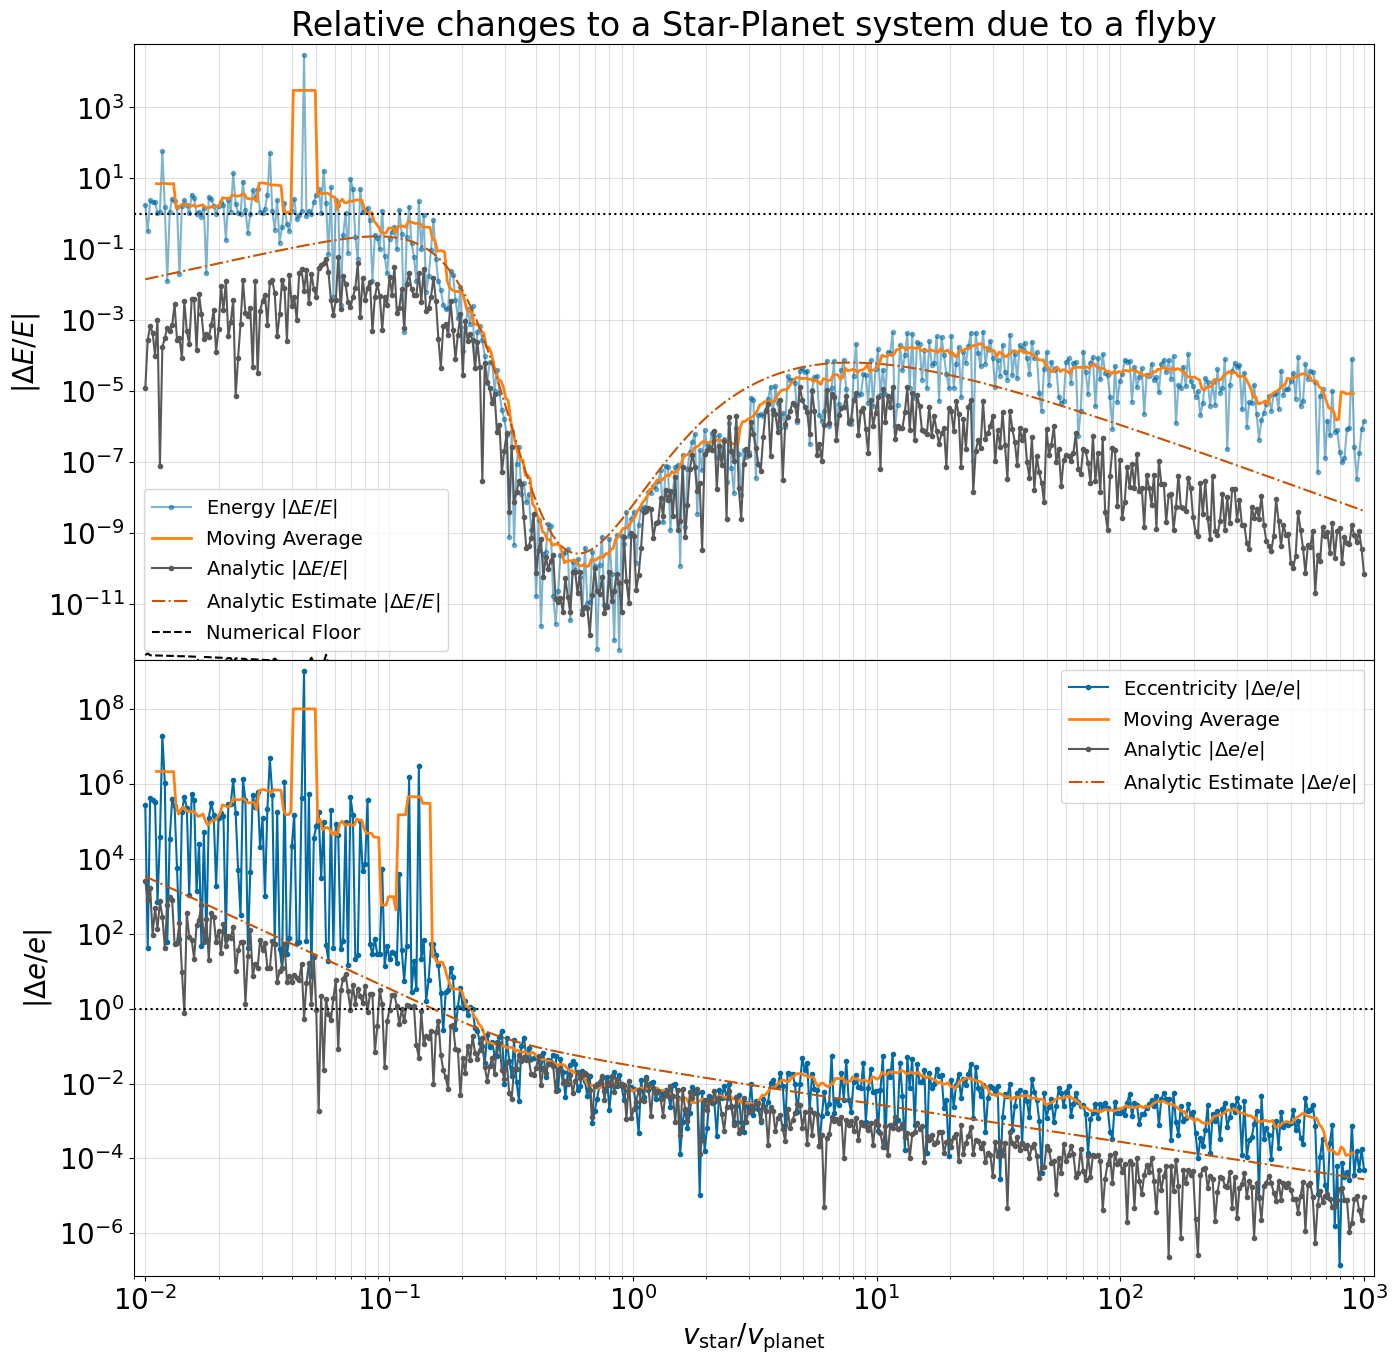

In [14]:
vs_v = star_vs/planet_v
est_dE = np.abs(airball.relative_energy_change(sun_mass, planet_mass, planet_a, planet_e, star_mass, star_b, star_vs, averaged=True))
est_de = np.abs(airball.eccentricity_change_adiabatic_estimate(sun_mass, planet_mass, planet_a, planet_e, star_mass, star_b, star_vs, averaged=True)/planet_e)

plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(2,1, figsize=(16,16), sharex=True)
ax[0].set_title('Relative changes to a Star-Planet system due to a flyby')

ax[0].plot(vs_v, dE, 'C0.-', alpha=0.5, label=r'Energy $|\Delta E/E|$')
ax[0].plot(ma(vs_v, n=10), ma(dE, n=10), 'C1-', lw=2, label='Moving Average')
ax[0].plot(vs_v, analytic_dE, 'C3.-', label=r'Analytic $|\Delta E/E|$')
ax[0].plot(vs_v, est_dE, 'C5-.', label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].plot(vs_v, 2.0**(-53.0) * np.sqrt(nsteps), 'k--', label='Numerical Floor')
ax[0].axhline(y=1, ls=':', c='k')
ax[0].legend(prop={'size': 14})
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].xaxis.grid(True, which='both', alpha=0.4)
ax[0].yaxis.grid(True, which='both', alpha=0.4)
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(vs_v)*0.9, np.max(vs_v)*1.1])
ax[0].set_ylim([np.min(dE)/2, np.max(dE)*2])

ax[1].plot(vs_v, de, 'C0.-', label=r'Eccentricity $|\Delta e/e|$')
ax[1].plot(ma(vs_v, n=10), ma(de, n=10), 'C1-', lw=2, label='Moving Average')
ax[1].plot(vs_v, analytic_de, 'C3.-', label=r'Analytic $|\Delta e/e|$')
ax[1].plot(vs_v, est_de, 'C5-.', label=r'Analytic Estimate $|\Delta e/e|$')
ax[1].axhline(y=1, ls=':', c='k')
ax[1].legend(prop={'size': 14})
ax[1].set_ylim([np.min([de,analytic_de])/2, np.max([de,analytic_de])*2])
ax[1].set_yscale('log')
ax[1].xaxis.grid(True, which='both', alpha=0.4)
ax[1].yaxis.grid(True, which='both', alpha=0.4)
ax[1].set_ylabel(r'$|\Delta e/e|$')
ax[1].set_xlabel(r'$v_\mathrm{star}/v_\mathrm{planet}$')

plt.subplots_adjust(hspace=0.)
plt.show()

## Making Hyperbolic Trajectories Figure

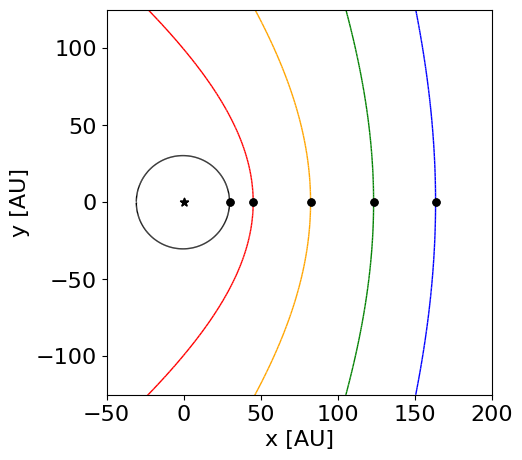

In [12]:
def be2a(b,e): return -b/np.sqrt(e**2. - 1.)

bs = [150, 200, 200, 250]
es = [1.2, 1.41, 2.23, 2.5]

sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=planet_mass, a=planet_a, e=planet_e)
for b,e in zip(bs,es):
    sim.add(a=be2a(b,e), e=e)

plt.rcParams.update({'font.size': 16})
rebound.OrbitPlot(sim, xlim=[-50,200], ylim=[-125,125], color=['black', 'red', 'orange', 'green', 'blue'], orbit_style="solid", unitlabel="[AU]", Narc=512)
fig.patch.set_facecolor('#E0E0E0')
plt.gca().set_aspect('equal')
plt.savefig('images/hyperbolic_trajectories.png', dpi=192, facecolor=fig.get_facecolor(), edgecolor='none', pad_inches=0.5, bbox_inches='tight')
plt.show()